## Load Ice Velocity Data

In [479]:
import numpy as np
import netCDF4

Data about ice sheet motion in Antarctica comes from NSIDC's [Antarctica Ice Velocity Map, Version 2](https://nsidc.org/data/nsidc-0484). The data set exports a 6.8 GB [NetCDF file](http://unidata.github.io/netcdf4-python/netCDF4/index.html).

In [480]:
f = netCDF4.Dataset('data/antarctica_ice_velocity_450m_v2.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: vel_nsidc.CF16.nc
    title: MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:  
    summary:  
    keywords:  
    keywords_vocabulary:  
    platform:  
    sensor:  
    date_created: 2017-04-06T17:47:44.00004923343322Z
    institution: Department of Earth System Science, University of California, Irvine
    cdm_data_type: Grid
    geospatial_lat_units: degrees_north
    geospatial_lon_units: degrees_east
    geospatial_lat_min: -90
    geospatial_lat_max: -60
    geospatial_lon_min: -180
    geospatial_lon_max: 180
    spatial_resolution: 450m
    time_coverage_start: 1995-01-01
    time_coverage_end: 2016-12-31
    project: NASA/MEaSUREs
    creator_name: J. Mouginot
    license: No restrictions

## Making a heatmap of ice velocity

We first retrieve the numpy arrays for the variables `VX` and `VY` (components of velocity in m/yr in x/y direction). We then convert the velocity components into magnitude (speed).

In [481]:
vel_x = f.variables['VX'][:]
vel_y = f.variables['VY'][:]
speed = (vel_x ** 2 + vel_y ** 2) ** 0.5

To decide a color scale, let's first see how speed is distributed.

Note: The data contain missing values (presumably for locations outside of Antarctica), so `VX` and `VY`, and thus `speed`, are [masked arrays](https://numpy.org/devdocs/reference/maskedarray.generic.html). We must first run it through [compressed](https://numpy.org/doc/1.18/reference/generated/numpy.ma.MaskedArray.compressed.html#numpy.ma.MaskedArray.compressed).

In [482]:
speed_values = speed.compressed()

In [483]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Ice speed distribution on a log scale')

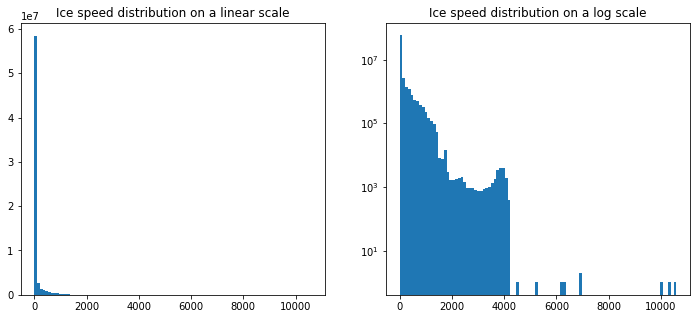

In [484]:
fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax_lin.hist(speed_values, bins = 100)
ax_lin.set_title('Ice speed distribution on a linear scale')

ax_log.hist(speed_values, bins = 100)
ax_log.set_yscale('log')
ax_log.set_title('Ice speed distribution on a log scale')

In the log graph there's a weirdly steep cutoff after ~5,000 m/yr but we'll ignore that for now. There are also a few outliers around 7,000 and 10,000. They might be worth annotating/investigating, or maybe they call for a different kind of scale (bins), but we'll do that later.

For now, we'll go with a linear scale maxed at ~2,300 and see what happens. TODO: Find a better way to generate this max value, or just scrap the linear scale.

In [485]:
SPEED_MAX = 2300

The next step is to map each speed to a color.

In [486]:
from matplotlib import cm, colors

We'll use a linear scale.

In [487]:
norm = colors.Normalize(vmin=0, vmax=SPEED_MAX)
color_map = cm.ScalarMappable(norm=norm, cmap='viridis')

The color map function is too slow, so we'll just do nearest-neighbor index stuff.

In [488]:
NUM_COLORS = 256

In [534]:
cmap = cm.get_cmap('viridis', NUM_COLORS)
cmap_colors = (cmap.colors * 255).tolist()

We convert all speeds to their `cmap_colors` indices. This takes advantage of numpy's vectorization speed, so we don't have to do this processing while we're looping through every value getting the colors.

In [490]:
speed_colors = np.rint(speed / SPEED_MAX * NUM_COLORS).astype(int)
speed_colors[speed_colors >= NUM_COLORS] = NUM_COLORS - 1

(Here we could do some image downsampling, but the code is fast enough for now that it's not necessary.)

In [492]:
# speed_scaled_smaller = speed_scaled[::2, ::2]
# speed_scaled_smaller.shape

Next, we ravel the array to make indexing easier. We also convert it into a list because this makes the list comprehension step a lot faster for some reason. (Remember that masked values become `None` after list conversion.)

In [518]:
speed_colors_list = speed_colors.ravel().tolist()

Now we can generate a 2D list with `speed_colors.size` rows and 4 columns.

In [535]:
%%time

EMPTY = [0, 0, 0, 0] # RGBA for missing value is just transparent
color_list = [ EMPTY if s is None else cmap_colors[s] for s in speed_colors_list ]

CPU times: user 11.3 s, sys: 1.25 s, total: 12.5 s
Wall time: 13.4 s


We then convert this back to a matrix matching the original dimensions. (We could do this without numpy since numpy conversion is a bit slow, but we need a numpy array for image processing anyways.)

During the conversion we also make the data-type an unsigned 8-bit integer (`np.uint8`) since `Image.fromarray` doesn't work well [with floating points](https://github.com/python-pillow/Pillow/issues/2856).

In [503]:
from itertools import chain

[Source for the following really fast array conversion.](https://stackoverflow.com/questions/17973507/why-is-converting-a-long-2d-list-to-numpy-array-so-slow) 

In [536]:
%%time

color_array = np.fromiter(chain.from_iterable(color_list), np.uint8).reshape(speed_colors.shape + (4,))

CPU times: user 32.8 s, sys: 1.07 s, total: 33.8 s
Wall time: 35 s


## Convert RGBA array to image

In [505]:
from PIL import Image

Finally, we create and show the image.

In [538]:
%%time

img = Image.fromarray(color_array, 'RGBA')
img.save('images/heatmap.png')
img.show()

CPU times: user 38.5 s, sys: 797 ms, total: 39.3 s
Wall time: 41.2 s
